# Figure 2: OIB magnetic basement tied to ANTOSTRAT seismic basement 
This notebook produces figure 2 of Tankersley et al. 2022. The figure shows the Werner deconvolution solutions and resulting magnetic basement depths, compared to seismic basement depths, for OIB flight 403, segment 1, in the Ross Sea.

In [1]:
# import necessary python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import copy
import pygmt
import os
import scipy.interpolate 

In [2]:
# all file paths assume this notebook is in /RIS_basement_sediment/Figures
pwd = os.getcwd()
pwd

'C:\\Users\\matthewt\\Documents\\Python_Scripts\\RIS_basement_sediment\\Figures'

## Load data

In [3]:
# import geosoft .csv with Werner solutions for OIB line 403, 404, and ROSETTA lines
file_in = '..\data\input\RIS123_1Hz_intermediate_Werner_2021_500_to_50k.csv'
df0 = pd.read_csv(file_in, header=0,index_col=None,sep=',')

# put line numbers into float format (L200 -> 200)
if type(df0.Line[0]) == str:
    df0.Line = df0.Line.str[1:]
df0['Line'] = pd.to_numeric(df0['Line']) 

# make dike solution depths be relative to sea level
# was relative to upwards continued flight elevation (1000masl)
df0['Depth'] = df0.Z_Dikes+1000

# if solutions are shallower then bathymetry, set equal to bathymetry
df0.Depth = np.where(df0.Depth>df0.bedmap2_bed, df0.bedmap2_bed, df0.Depth)  

# copy df to retain magnetics data to use in plotting
df_mag=copy.deepcopy(df0)

# drop columns and NaNs for oib dataset
df0_oib=df0.drop(df0.columns.difference(['Line','Distance','x','y','ANTOSTRAT_basement',
                                         'bedmap2_bed','Susc','Window_Width','Depth']), axis=1)
df0_oib.dropna(how='any', subset=('Line','Distance','x','y','Susc','Window_Width','Depth'), inplace=True)

# drop columns and NaNs for rosetta dataset
df0_rs=df0.drop(df0.columns.difference(['Line','Distance','x','y','bedmap2_bed', 
                                        'Susc','Window_Width','Depth']), axis=1)
df0_rs.dropna(how='any', subset=('Line','Distance','x','y','Susc','Window_Width','Depth'), inplace=True)

## Apply filtering and binning process

In [4]:
Line_oib=403.3
oib_parameter_s=1
oib_parameter_w=10000
oib_parameter_b=36000
oib_parameter_c=6

# isolate an individual line
oib = df0_oib[df0_oib.Line==Line_oib].copy()
oib_mag = df_mag[df_mag.Line==Line_oib]

# make sure ANTOSTRAT column is filled
oib.ANTOSTRAT_basement.interpolate(method='linear', axis=0, inplace=True, limit_area='inside')

# retain oib dataframe before filtering is applied
oib_filt=copy.deepcopy(oib)

"""
filter solutions based on susceptibility and window width
add filtered solutions depths and distances to new columns
i.e. Distance_36k and Depth_36k for iterations where b=36km
"""
Distance_name = 'Distance_'+(str(int(oib_parameter_b/1000))+'k')
Depth_name ='Depth_'+(str(int(oib_parameter_b/1000))+'k')
oib_filt = pd.concat([oib_filt,pd.DataFrame(columns=[Distance_name, Depth_name])]) # add above columns to oib
oib_filt[Distance_name] = np.floor(oib_filt.Distance[(oib_filt.Susc > oib_parameter_s) & 
                                                     (oib_filt.Window_Width < oib_parameter_w)]/oib_parameter_b)*oib_parameter_b 
oib_filt[Depth_name] = oib_filt.Depth[(oib_filt.Susc > oib_parameter_s) & (oib_filt.Window_Width < oib_parameter_w)]

oib_filt.dropna(inplace=True) # remove rows with NaNs

# Set bin centers equal to 95% depth of solutions within bin
def quant(x):
    return x.quantile(0.95)
# new df with only binned points, with distances set to the center of the bins and depths set to 95% of all points within bins
oib_bin_centers = oib_filt.groupby([Distance_name], as_index=False).agg({Depth_name: quant})
oib_bin_centers['Distance'] = oib_bin_centers[Distance_name]+(oib_parameter_b/2)
oib_bin_centers['binned']=1 # keep track of binned points

# rename Depth_name column so oib_bin_centers can be merged
oib_filt.rename(columns={Depth_name:'Depth_filtered'}, inplace=True)

# add the binned solutions to oib_filt
oib_filt_with_centers = oib_filt.set_index(['Distance', Distance_name]).join(oib_bin_centers.set_index(['Distance', Distance_name]), how='outer')
oib_filt_with_centers.reset_index(inplace=True)
oib_filt_with_centers.sort_values(['Distance'], inplace=True)
#fill nan's in columns, except 'binned'
for col in oib_filt_with_centers.columns:
    if col == 'binned':
        pass
    else:
        oib_filt_with_centers[col].interpolate(method='linear', limit_direction='both', inplace=True)    

"""
retain only the bins which contain a minumum number (count) of points
"""
# number of filtered points within each bin
oib_filt_with_centers['counts'] = oib_filt_with_centers.groupby([Distance_name])['Depth_filtered'].transform('count')
oib_bin_centers=oib_filt_with_centers[oib_filt_with_centers.binned.notna()]
oib_bin_centers=oib_bin_centers[oib_bin_centers.counts>oib_parameter_c]

"""
Compare OIB basement results with ANTOSTRAT basement results
"""
# interpolate line between binned points for comparison with ANTOSTRAT
x1 = min(oib_bin_centers.Distance)
x2 = max(oib_bin_centers.Distance)
increment = 5000  #sample every 5k for optimization, every 1km of uncertainty analysis
Distance_new = np.arange(x1, x2, increment)  # creates array for distance to interpolate onto, 1 point every 5km
window = int(30000/increment) # window size for filtering resulting interpolated line

# define function which takes distance, and gives interpolated depths
f = scipy.interpolate.interp1d(oib_bin_centers.Distance, oib_bin_centers[Depth_name], kind='quadratic', fill_value='extrapolate') 
# apply function to new distance array
oib_basement=f(Distance_new)  
# add new distances and interpolated depth to dataframe
oib_solutions=pd.DataFrame(data={'Distance':Distance_new, 'oib_basement':oib_basement})
# smooth the interpolated depths with a rolling mean window 
oib_solutions['oib_basement_filt'] = oib_solutions.oib_basement.rolling(window, center=True).mean()
oib_solutions.sort_values(['Distance'], inplace=True)
# add 'oib_basement' and 'oib_basement_filt' columns to database to get x, y, etc. 
df_oib_basement=oib_filt_with_centers.set_index('Distance').join(oib_solutions.set_index('Distance'), how='outer')
df_oib_basement.reset_index(inplace=True)
df_oib_basement.sort_values(['Distance'], inplace=True)
# fill nans in all columns except 'oib_basement_filt' to get x, y, etc. for interpolated basement line
for col in df_oib_basement.columns:
    if col == 'oib_basement_filt':
        pass
    else:
        df_oib_basement[col].interpolate(method='linear', limit_area='inside', inplace=True)    
# drop all rows except for interpolate basement line
# df_oib_basement.dropna(inplace=True)
df_oib_basement.dropna(subset=['oib_basement_filt'], inplace=True)
# if solutions are shallower then bathymetry, set equal to bathymetry
df_oib_basement['filt_clip'] = np.where(df_oib_basement.oib_basement_filt>df_oib_basement.bedmap2_bed,
                                            df_oib_basement.bedmap2_bed, df_oib_basement.oib_basement_filt)
"""
compare resulting interpolated line with coincident ANTOSTRAT basement 
"""
df_oib_basement['misfit'] = df_oib_basement.ANTOSTRAT_basement - df_oib_basement.filt_clip 
df_oib_basement['abs_misfit'] = np.abs(df_oib_basement.misfit)
mean_misfit=df_oib_basement.abs_misfit.mean()
median_misfit=df_oib_basement.abs_misfit.median()

## Plot figure

C:\Users\matthewt\AppData\Local\Temp\ipykernel_27584\4131237417.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


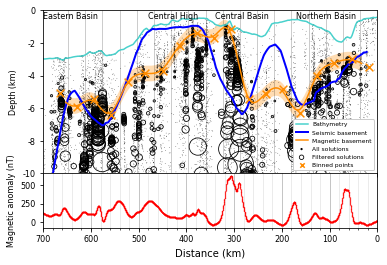

In [6]:
# initialize the figure
fig = plt.figure()
gs = gridspec.GridSpec(2,1, height_ratios=[3,1])
ax0 = fig.add_subplot(gs[0])

#vertical lines of bin size
ax0.vlines(oib_filt_with_centers.Distance_36k.unique(),ymin=-10000, ymax=0, color='k', linewidth=1).set_alpha(.2)    

# bedmap2 bathymetry
ax0.plot(oib.Distance, oib.bedmap2_bed, 
         c='mediumturquoise', linewidth=1.5, label='Bathymetry')

# ANTOSTRAT basement  
ax0.plot(oib.Distance,oib.ANTOSTRAT_basement,  
         c='blue', linewidth=2, label='Seismic basement')

# interpolated OIB basement
ax0.plot(df_oib_basement.Distance, df_oib_basement.filt_clip, 
         c='darkorange', 
         label='Magnetic basement')

# uncertainty bounds
error=480
ax0.fill_between(df_oib_basement.Distance, 
                 df_oib_basement.filt_clip-error, 
                 df_oib_basement.filt_clip+error,
                 facecolor='darkorange', alpha=.3)
       
# OIB Werner dike solutions
ax0.scatter(oib.Distance, oib.Depth, 
            s = 1.5, marker='.', edgecolor='none', facecolor='k', 
            label='All solutions')

# OIB filtered solutions, scaled by Susc
ax0.scatter(oib_filt.Distance, oib_filt.Depth, 
            s = oib_filt.Susc*3, marker='o', edgecolors='k', facecolors='none', 
            linewidth=.8, label='Filtered solutions')

# binned OIB basement solutions
ax0.scatter(oib_bin_centers.Distance, oib_bin_centers.Depth_36k, 
            marker='x', c='darkorange', s=60, zorder=15, 
            label='Binned points')


# OIB magnetics    
ax1 = fig.add_subplot(gs[1], sharex=ax0)

ax1.scatter(oib_mag.Distance, oib_mag.Mag_anom_draped_1000, 
            s=.05, c='r', label='ROSETTA')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")   

#### SET TICKS / LIMITS    
ax1.set_xlim(oib.Distance.max(), oib.Distance.min()) 
ax1.set_xticks(np.arange(oib.Distance.min(), oib.Distance.max(), 100000))
ax1.set_xticklabels(np.arange(0, int((oib.Distance.max())/1000), 100))
ax1.set_xticks(np.arange(0, int((oib.Distance.max())), 20000), minor=True)
ax1.tick_params(axis='both', labelsize=8)
ax0.tick_params(axis='both', labelsize=8)

ax0.set_ylim(-10000, 0)
ax0.set_yticks((-10000, -8000, -6000, -4000, -2000, 0))
ax0.set_yticklabels((-10, -8, -6, -4, -2, 0))

ax1.set_axisbelow(True)
ax1.grid(axis='x', which='major', alpha=0.8)
ax1.grid(axis='x', which='minor', alpha=0.3)
ax0.set_ylabel('Depth (km)', size=8)
ax1.set_ylabel('Magnetic anomaly (nT)', size=8)
ax1.set_xlabel('Distance (km)')
lgnd = ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)
lgnd.legendHandles[-3]._sizes = [20]
lgnd.legendHandles[-2]._sizes = [20]
lgnd.legendHandles[-1]._sizes = [20]

ax0.text(x=700000, y=-500, s='Eastern Basin', fontsize=8)
ax0.text(x=480000, y=-500, s='Central High', fontsize=8)
ax0.text(x=340000, y=-500, s='Central Basin', fontsize=8)
ax0.text(x=170000, y=-500, s='Northern Basin', fontsize=8)

fig.subplots_adjust(hspace=0)
plt.setp(ax0.get_xticklabels(),visible=False)

# fig.show()

In [ ]:
out='outputs/FigS2_OIB_403_3.jpg'
fig.savefig(out, dpi=200)